In [1]:
# Import all of the python packages used in this workflow.
import scipy
import numpy as np
from collections import OrderedDict
import os, sys
from pylab import *
import pandas as pd
import numpy as np
import osr
import xarray as xr
import geopandas as gpd
from datetime import datetime
from datetime import timedelta  
import json
import matplotlib.pyplot as plt

#from sklearn.covariance import EmpiricalCovariance, MinCovDet

In [50]:
########## USER ###########
# Select modeling domain ('WY', 'UT', 'OR', 'WA')
domain = 'WA'

# SM location 
SMpath = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhillWA/'

In [51]:
# Outfile path
outpath = '/nfs/attic/dfh/Aragon2/CSOdata/'+domain+'/'
# Figure path
figpath = '/nfs/attic/dfh/Aragon2/CSOfigs/'+domain+'/'

#path to CSO domain json
with open('/nfs/attic/dfh/Aragon2/CSOdata/CSO_domains.json') as f:
    domains = json.load(f)

#start date    
st = domains[domain]['st']
#end date
ed = domains[domain]['ed']

#Snotel bounding box
Bbox = domains[domain]['Bbox']

# Snotel projection
stn_proj = domains[domain]['stn_proj']
# model projection
mod_proj = domains[domain]['mod_proj']

In [52]:
gdf = gpd.read_file(outpath+'CSO_SNOTEL_sites.geojson')
df = pd.read_csv(outpath+'CSO_SNOTEL_data_SWEDmeters.csv') 
gdf.head()

,code,longitude,latitude,name,elevation_m,easting,northing,geometry
0,515_WA_SNTL,-120.658600,48.720470,Harts Pass,1978.1519775390625,672206.061972,5.399027e+06,POINT (-120.65860 48.72047)
1,1259_WA_SNTL,-119.866241,48.585258,Muckamuck,1362.4560546875,731093.783565,5.386094e+06,POINT (-119.86624 48.58526)
2,681_WA_SNTL,-120.915512,48.444881,Park Creek Ridge,1402.0799560546875,654147.805738,5.367848e+06,POINT (-120.91551 48.44488)
3,711_WA_SNTL,-120.735802,48.518650,Rainy Pass,1490.4720458984375,667193.866770,5.376424e+06,POINT (-120.73580 48.51865)
4,728_WA_SNTL,-119.838303,48.655182,Salmon Meadows,1359.407958984375,732831.734842,5.393950e+06,POINT (-119.83830 48.65518)


In [53]:
# calibration_2020-05-24_full_set.nc the MAE metric is actually r**2
data = xr.open_dataset(outpath+'calibration_2020-07-21_full_set.nc')
data

<xarray.Dataset>
Dimensions:          (calibration_run: 10752, metric: 5, station: 7)
Coordinates:
  * calibration_run  (calibration_run) int64 0 1 2 3 ... 10748 10749 10750 10751
  * metric           (metric) object 'R2' 'MBE' 'RMSE' 'NSE' 'KGE'
  * station          (station) object '515_WA_SNTL' ... '817_WA_SNTL'
Data variables:
    cal_metrics      (calibration_run, metric, station) float64 ...
Attributes:
    description:             SnowModel line calibration performance metrics
    calibration_parameters:  ro_snowmax,cf_precip_scalar,ro_adjust
    model_parameter:         SWE [m]

In [54]:
#'cal_params_2020-07-03_full_set.csv'
calibration = pd.read_csv(outpath+'cal_params_2020-07-21_full_set.csv')
calibration.head()

,lat_solar_flag,lapse_rate,prec_lapse_rate,ro_snowmax,cf_precip_scalar,ro_adjust,gap_frac
0,0,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",350.0,0.7,4.0,0.0
1,0,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",350.0,0.7,4.0,0.2
2,0,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",350.0,0.7,4.0,0.4
3,0,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",350.0,0.7,4.0,0.6
4,0,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",350.0,0.7,5.0,0.0


# Find average top performing metrics 
For a given OF, take the average skill score across all stations

In [55]:
NSE = data.cal_metrics.loc[:,"NSE",:]
nse_top = np.amax(data.cal_metrics.loc[:,"NSE",:],axis = 0)
KGE = data.cal_metrics.loc[:,"KGE",:]
kge_top = np.amax(data.cal_metrics.loc[:,"KGE",:],axis = 0)
RMSE = data.cal_metrics.loc[:,"RMSE",:]
rmse_top = np.amin(data.cal_metrics.loc[:,"RMSE",:],axis = 0)
R_2 = data.cal_metrics.loc[:,"R2",:]
r2_top = np.amax(data.cal_metrics.loc[:,"R2",:],axis = 0)
MBE = data.cal_metrics.loc[:,"MBE",:]
mbe_top = np.amin(data.cal_metrics.loc[:,"MBE",:],axis = 0)

print('maxNSE:', r2_top)

maxNSE: <xarray.DataArray 'cal_metrics' (station: 7)>
array([0.94176598, 0.85286098, 0.93971211, 0.95363147, 0.94070514,
       0.8704936 , 0.91569513])
Coordinates:
    metric   <U2 'R2'
  * station  (station) object '515_WA_SNTL' '1259_WA_SNTL' ... '817_WA_SNTL'


Text(0.5, 1.0, 'R**2')

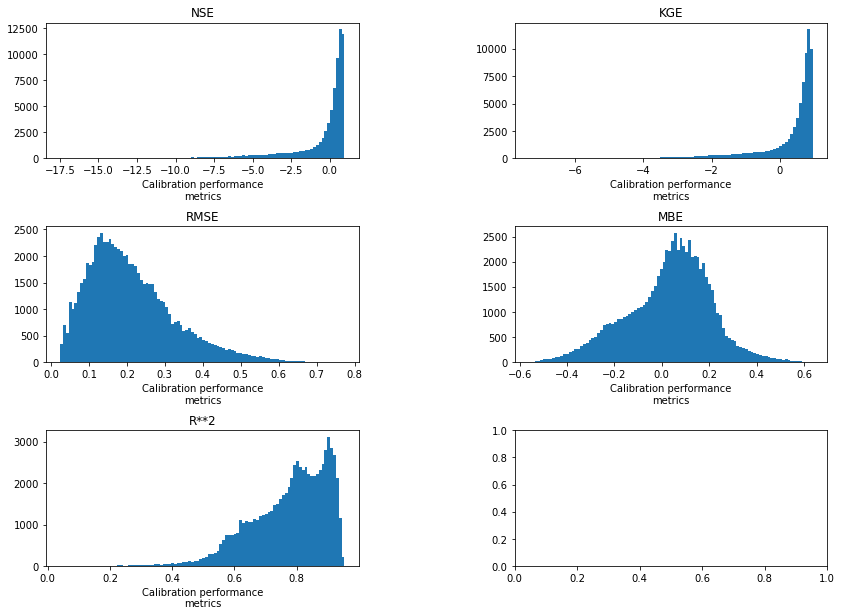

In [56]:
fig, axes = plt.subplots(ncols=2,nrows=3,figsize=(14, 10))
fig.subplots_adjust(hspace = .5, wspace=.5)
NSE.plot.hist(ax=axes[0,0],bins=100)
axes[0,0].set_title('NSE')
KGE.plot.hist(ax=axes[0,1],bins=100)
axes[0,1].set_title('KGE')
RMSE.plot.hist(ax=axes[1,0],bins=100)
axes[1,0].set_title('RMSE')
MBE.plot.hist(ax=axes[1,1],bins=100)
axes[1,1].set_title('MBE')
R_2.plot.hist(ax=axes[2,0],bins=100)
axes[2,0].set_title('R**2')

In [57]:
#fig.savefig(figpath+domain+'_domain_cal_metrics.pdf', format='pdf', dpi=300)

### Data frame of metrics averaged over domain for each model run

In [58]:
x = np.empty((len(calibration),5))
x[:,0] = np.mean(NSE.values,axis=1)
x[:,1] = np.mean(KGE,axis=1).values
x[:,2] = np.mean(RMSE,axis=1).values
x[:,3] = np.mean(R_2,axis=1).values
x[:,4] = np.mean(MBE,axis=1).values

dataav = pd.DataFrame(x,columns=['NSE', 'KGE', 'RMSE','R_2','MBE'])
dataav
#dataav.to_csv('calibration_params.csv')

,NSE,KGE,RMSE,R_2,MBE
0,0.145518,0.530762,0.232763,0.705615,-0.181470
1,-0.132051,0.350973,0.270528,0.587951,-0.212179
2,-0.374348,0.180798,0.297316,0.490727,-0.233706
3,-0.605826,0.007604,0.319470,0.396277,-0.251470
4,0.121763,0.515639,0.235247,0.698808,-0.184073
...,...,...,...,...,...
10747,-4.625244,-1.605582,0.336188,0.766932,0.263109
10748,-6.445430,-2.394217,0.460554,0.568289,0.351605
10749,-5.738239,-2.071909,0.418462,0.630135,0.323267
10750,-5.128518,-1.811911,0.373803,0.705472,0.292431


Text(0.5, 1.0, 'R**2')

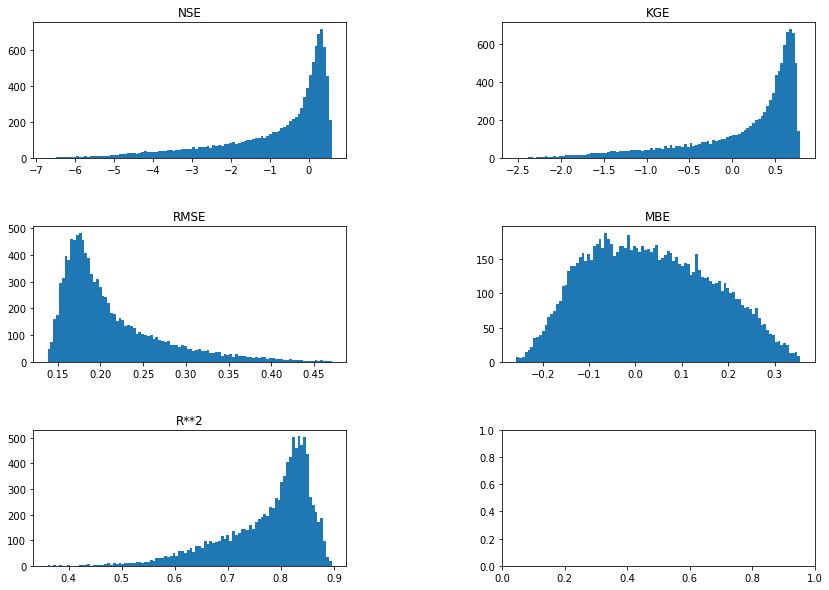

In [59]:
fig, axs = plt.subplots(3, 2,figsize=(14, 10))
fig.subplots_adjust(hspace = .5, wspace=.5)
axs[0, 0].hist(dataav['NSE'],bins=100)
axs[0, 0].set_title('NSE')
axs[0, 1].hist(dataav['KGE'],bins=100)
axs[0, 1].set_title('KGE')
axs[1, 0].hist(dataav['RMSE'],bins=100)
axs[1, 0].set_title('RMSE')
axs[1, 1].hist(dataav['MBE'],bins=100)
axs[1, 1].set_title('MBE')
axs[2, 0].hist(dataav['R_2'],bins=100)
axs[2, 0].set_title('R**2')

In [60]:
#fig.savefig(figpath+domain+'_domain_cal_metrics_averaged.pdf', format='pdf', dpi=300)

In [61]:
def get_top_idx(metric):
    if (metric == 'R_2') | (metric == 'NSE')|(metric == 'KGE'):
        x = dataav[metric].values
        index = np.where(x==np.max(x))
    elif (metric == 'MBE'):
        x = np.abs(dataav['MBE']).values
        index = np.where(x==np.min(x))
    elif (metric == 'RMSE'):
        x = dataav[metric]
        index = np.where(x==np.min(x))
    return index[0][0]


top_params = []

top_params.append(get_top_idx('R_2'))
top_params.append(get_top_idx('MBE'))
top_params.append(get_top_idx('RMSE'))
top_params.append(get_top_idx('NSE'))
top_params.append(get_top_idx('KGE'))

top_params

[8133, 6583, 5588, 9424, 4064]

In [62]:
#the parameters for the top performing runs
topav = calibration.iloc[top_params]
topav = topav.reset_index(drop=True)
topav

,lat_solar_flag,lapse_rate,prec_lapse_rate,ro_snowmax,cf_precip_scalar,ro_adjust,gap_frac
0,1,".28,1.2,2.8,4.2,4.5,4.4,4.0,3.8,3.7,3.4,2.6,0.87","0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",350.0,1.2,6.0,0.2
1,1,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",700.0,0.9,5.0,0.6
2,1,"4.4,5.9,7.1,7.8,8.1,8.2,8.1,8.1,7.7,6.8,5.5,4.7","0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...",400.0,1.0,6.0,0.0
3,1,".28,1.2,2.8,4.2,4.5,4.4,4.0,3.8,3.7,3.4,2.6,0.87","0.4,0.4,0.46,0.41,0.27,0.24,0.21,0.17,0.22,0.3...",350.0,0.8,5.0,0.0
4,0,".28,1.2,2.8,4.2,4.5,4.4,4.0,3.8,3.7,3.4,2.6,0.87","0.4,0.4,0.46,0.41,0.27,0.24,0.21,0.17,0.22,0.3...",350.0,0.9,6.0,0.0


### Heatmap of top performing runs 

In [63]:
#https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, vmin=-1, vmax=1, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


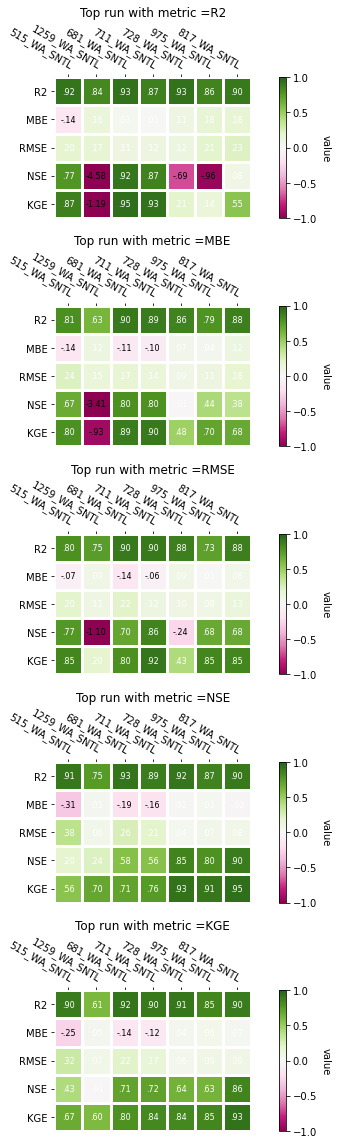

In [64]:
Metrics = ['R2','MBE','RMSE','NSE','KGE']
Stations = gdf['code'].values

def func(x, pos):
    return "{:.2f}".format(x).replace("0.", ".").replace("1.00", "")

fig, ((ax), (ax1), (ax2), (ax3),(ax4)) = plt.subplots(5, 1, figsize=(8,16))

# Replicate the above example with a different font size and colormap.
im, cbar = heatmap(data.cal_metrics[top_params[0],:,:], Metrics, Stations, ax=ax,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax.set_title('Top run with metric ='+Metrics[0])

im, _ = heatmap(data.cal_metrics[top_params[1],:,:], Metrics, Stations, ax=ax1,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax1.set_title('Top run with metric ='+Metrics[1])

im, _ = heatmap(data.cal_metrics[top_params[2],:,:], Metrics, Stations, ax=ax2,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax2.set_title('Top run with metric ='+Metrics[2])

im, _ = heatmap(data.cal_metrics[top_params[3],:,:], Metrics, Stations, ax=ax3,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax3.set_title('Top run with metric ='+Metrics[3])

im, _ = heatmap(data.cal_metrics[top_params[4],:,:], Metrics, Stations, ax=ax4,
                   cmap="PiYG", cbarlabel="value")
annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(func), size=8)
ax4.set_title('Top run with metric ='+Metrics[4])


plt.tight_layout()
plt.show()

In [65]:
fig.savefig(figpath+domain+'_heatmap_averaged.pdf', format='pdf', dpi=300)

## Re-run SM with optimal configurations identified above

In [66]:
parFile = SMpath+'snowmodel.par'
incFile = SMpath+'code/snowmodel.inc'
compileFile = SMpath+'code/compile_snowmodel.script'
ctlFile = SMpath+'ctl_files/wo_assim/swed.ctl'
sweFile = SMpath+'outputs/wo_assim/swed.gdat'
codepath = SMpath+'code'
calpath = '/nfs/attic/dfh/Aragon2/Notebooks/calibration_python'

In [67]:
#Edit the par file to set parameters with new values
def edit_par(par_dict,parameter,new_value):
    lines = open(parFile, 'r').readlines()
    if par_dict[parameter][2] == 14 or par_dict[parameter][2] == 17 \
    or par_dict[parameter][2] == 18 or par_dict[parameter][2] == 19 \
    or par_dict[parameter][2] == 93 or par_dict[parameter][2] == 95 \
    or par_dict[parameter][2] == 97 or par_dict[parameter][2] == 100 \
    or par_dict[parameter][2] == 102 or par_dict[parameter][2] == 104 \
    or par_dict[parameter][2] == 107 or par_dict[parameter][2] == 108:
        text = str(new_value)+'\n'
    else:
        text = str(new_value)+'\t\t\t!'+par_dict[parameter][1]
    lines[par_dict[parameter][2]] = text
    out = open(parFile, 'w')
    out.writelines(lines)
    out.close()

In [68]:
with open('par_base.json') as f:
    base = json.load(f)
    
for key in base:
    edit_par(base,key,base[key][0])
    
#edit snowmodel.par
edit_par(base,'nx',np.shape(gdf)[0])
edit_par(base,'ny',1)
edit_par(base,'xmn',domains[domain]['xll'])
edit_par(base,'ymn',domains[domain]['yll'])
edit_par(base,'dt',21600) 
edit_par(base,'iyear_init',datetime.strptime(domains[domain]['st'],'%Y-%m-%d').year)
edit_par(base,'imonth_init',datetime.strptime(domains[domain]['st'],'%Y-%m-%d').month)
edit_par(base,'iday_init',datetime.strptime(domains[domain]['st'],'%Y-%m-%d').day)
edit_par(base,'xhour_init',datetime.strptime(domains[domain]['st'],'%Y-%m-%d').hour)
edit_par(base,'max_iter',(datetime.strptime(domains[domain]['ed'],'%Y-%m-%d')-
    datetime.strptime(domains[domain]['st'],'%Y-%m-%d')).days*4+4)
edit_par(base,'met_input_fname','../CSOdmn/'+domain+'/mm_'+domain+'_2014-2019.dat')
edit_par(base,'ascii_topoveg',1)
edit_par(base,'topo_ascii_fname','../CSOdmn/'+domain+'/DEM_'+domain+'.asc')
edit_par(base,'veg_ascii_fname','../CSOdmn/'+domain+'/NLCD2016_'+domain+'.asc')
edit_par(base,'xlat',40.2)
edit_par(base,'run_snowtran',0)
edit_par(base,'barnes_lg_domain',1)
edit_par(base,'snowmodel_line_flag',1)
edit_par(base,'lapse_rate','.28,1.2,2.8,4.2,4.5,4.4,4.0,3.8,3.7,3.4,2.6,0.87')#
edit_par(base,'prec_lapse_rate','0.4,0.4,0.46,0.41,0.27,0.24,0.21,0.17,0.22,0.32,0.43,0.39')#
edit_par(base,'print_inc',4)
edit_par(base,'print_var_01','n')
edit_par(base,'print_var_09','n')
edit_par(base,'print_var_10','n')
edit_par(base,'print_var_11','n')
edit_par(base,'print_var_12','n')
edit_par(base,'print_var_14','n')
edit_par(base,'print_var_18','y')
edit_par(base,'snowfall_frac',3)
edit_par(base,'cf_precip_flag',3)

In [69]:
num_sim_days = (datetime.strptime(domains[domain]['ed'],'%Y-%m-%d')-
                datetime.strptime(domains[domain]['st'],'%Y-%m-%d')).days+1
def get_mod_output_line(inFile):
    #open the grads model output file, 'rb' indicates reading from binary file
    grads_data = open(inFile,'rb')
    # convert to a numpy array 
    numpy_data = np.fromfile(grads_data,dtype='float32',count=-1)
    #close grads file 
    grads_data.close()
    #reshape the data
    numpy_data = np.reshape(numpy_data,(num_sim_days,1,np.shape(gdf)[0]))
    #swe only at station point
    data = np.squeeze(numpy_data[:,0,:]) 

    return data

In [70]:
%%time
%cd $SMpath

top_swe = np.empty([len(top_params),num_sim_days,np.shape(gdf)[0]])
for i in range(len(top_params)):
    edit_par(base,'lat_solar_flag',calibration.lat_solar_flag[top_params[i]])
    edit_par(base,'lapse_rate',calibration.lapse_rate[top_params[i]])
    edit_par(base,'prec_lapse_rate',calibration.prec_lapse_rate[top_params[i]])
    edit_par(base,'ro_snowmax',calibration.ro_snowmax[top_params[i]])
    edit_par(base,'cf_precip_scalar',calibration.cf_precip_scalar[top_params[i]])
    edit_par(base,'ro_adjust',calibration.ro_adjust[top_params[i]]) 
    ! nohup ./snowmodel
    mod_swe = get_mod_output_line(sweFile)
    top_swe[i,:,:] = mod_swe

%cd $calpath

/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhillWA
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
nohup: ignoring input and appending output to ‘nohup.out’
/nfs/attic/dfh/Aragon2/Notebooks/calibration_python
CPU times: user 34.6 ms, sys: 54.8 ms, total: 89.4 ms
Wall time: 25.6 s


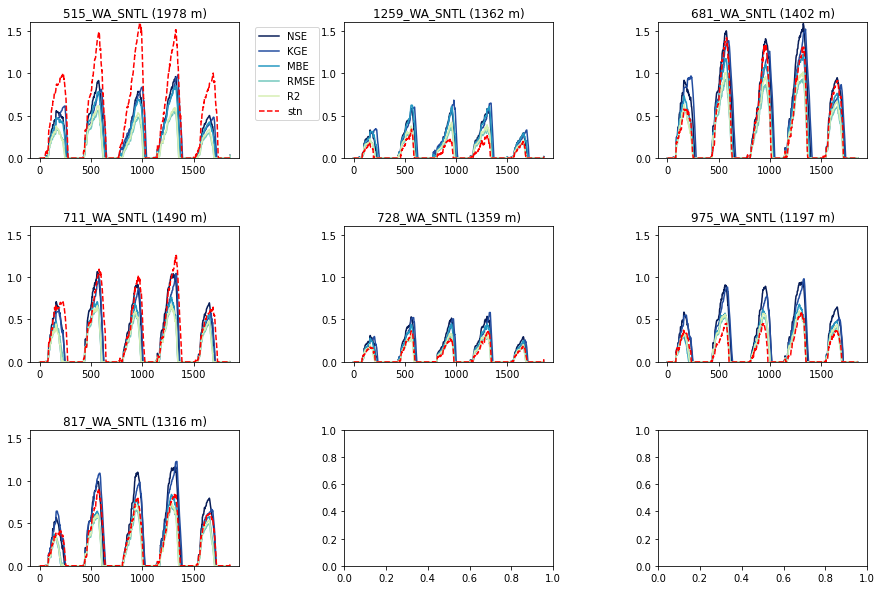

In [71]:
elev = gdf['elevation_m'].values
station = gdf['code'].values

from matplotlib.pyplot import cm

n=np.shape(top_swe)[0] 

#YlGnBu
#WY: nrows=10,figsize=(15, 30); 
#OR: nrows=4, figsize=(15, 15); 
#WA: nrows=3, figsize=(15, 10)
#UT: nrows=2, figsize=(15, 8)
fig, axs = plt.subplots(nrows=3, figsize=(15, 10), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(gdf)[0]):
    nam = station[i]
    el = elev[i]
    x = df[nam].values
    mod = np.squeeze(top_swe[:,:,i])
    color=iter(cm.YlGnBu_r(np.linspace(0,1,n+1)))
    for j in range(n):
        c=next(color)
        axs[i].plot(np.transpose(mod[j,:]),c=c)
    axs[i].plot(x,'r--')
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    axs[i].set_ylim([0, 1.6])
    if i == 0:
        axs[i].legend(['NSE', 'KGE', 'MBE','RMSE','R2','stn'],bbox_to_anchor=(1.05, 1), loc='upper left',)

In [72]:
fig.savefig(figpath+domain+'_SWE_top_calmetrics_2020-07_21_av.pdf', format='pdf', dpi=300)

# Top ranked score

-> each OF is ranked independently

-> the rank scores are summed across each model run 

-> The summed scores are then ranked and the top scores are used to identify the top model parameter combinations

In [73]:
dataav['NSE_rank']=dataav['NSE'].rank(ascending=False)
dataav['KGE_rank']=dataav['KGE'].rank(ascending=False)
dataav['R_2_rank']=dataav['R_2'].rank(ascending=False)
dataav['RMSE_rank']=dataav['RMSE'].rank()
dataav['MBE_rank']=np.abs(dataav['MBE']).rank()
dataav['score']=dataav['NSE_rank']+ dataav['KGE_rank']+dataav['R_2_rank']+ dataav['RMSE_rank']+dataav['MBE_rank']
dataav['score_rank'] = dataav['score'].rank()
dataav.head()

,NSE,KGE,RMSE,R_2,MBE,NSE_rank,KGE_rank,R_2_rank,RMSE_rank,MBE_rank,score,score_rank
0,0.145518,0.530762,0.232763,0.705615,-0.181470,3358.0,4156.0,8691.0,7914.0,8680.0,32799.0,7267.0
1,-0.132051,0.350973,0.270528,0.587951,-0.212179,4994.0,5877.0,10360.0,9118.0,9459.0,39808.0,8739.5
2,-0.374348,0.180798,0.297316,0.490727,-0.233706,5831.0,6870.0,10677.0,9669.0,9867.0,42914.0,9293.0
3,-0.605826,0.007604,0.319470,0.396277,-0.251470,6444.0,7570.0,10742.0,9986.0,10116.0,44858.0,9595.0
4,0.121763,0.515639,0.235247,0.698808,-0.184073,3529.0,4355.0,8830.0,8021.0,8758.0,33493.0,7417.5


In [74]:
rank_params = np.where((dataav['score_rank']==min(dataav['score_rank'])))
top_params = rank_params[0]
label = dataav['score_rank'][top_params].values
top_params

array([9524])

In [75]:
#the parameters for the top performing runs
toprank = calibration.iloc[top_params]
#toprank = dataav.iloc[top_params]
toprank

,lat_solar_flag,lapse_rate,prec_lapse_rate,ro_snowmax,cf_precip_scalar,ro_adjust,gap_frac
9524,1,".28,1.2,2.8,4.2,4.5,4.4,4.0,3.8,3.7,3.4,2.6,0.87","0.4,0.4,0.46,0.41,0.27,0.24,0.21,0.17,0.22,0.3...",375.0,0.9,6.0,0.0


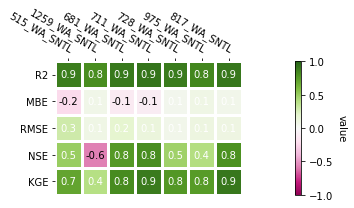

In [76]:
Metrics = ['R2','MBE','RMSE','NSE','KGE']
Stations = gdf['code'].values

for i in range(len(toprank)):
    fig, ax = plt.subplots(figsize=(15, 3))
    im, cbar = heatmap(data.cal_metrics[top_params[i],:,:], Metrics, Stations, ax=ax,
                       cmap="PiYG", cbarlabel="value")
    texts = annotate_heatmap(im,valfmt="{x:.1f}")
    #ax.set_title('Top run with metric ='+Metrics[i])
    fig.tight_layout()
    plt.show()
    

In [77]:
fig.savefig(figpath+domain+'_heatmap_rank.pdf', format='pdf', dpi=300)

In [78]:
%%time
%cd $SMpath

top_swe = np.empty([len(top_params),num_sim_days,np.shape(gdf)[0]])
for i in range(len(top_params)):
    edit_par(base,'lat_solar_flag',calibration.lat_solar_flag[top_params[i]])
    edit_par(base,'lapse_rate',calibration.lapse_rate[top_params[i]])
    edit_par(base,'prec_lapse_rate',calibration.prec_lapse_rate[top_params[i]])
    edit_par(base,'ro_snowmax',calibration.ro_snowmax[top_params[i]])
    edit_par(base,'cf_precip_scalar',calibration.cf_precip_scalar[top_params[i]])
    edit_par(base,'ro_adjust',calibration.ro_adjust[top_params[i]]) 
    ! nohup ./snowmodel
    mod_swe = get_mod_output_line(sweFile)
    top_swe[i,:,:] = mod_swe

%cd $calpath

/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhillWA
nohup: ignoring input and appending output to ‘nohup.out’
/nfs/attic/dfh/Aragon2/Notebooks/calibration_python
CPU times: user 5.39 ms, sys: 16 ms, total: 21.4 ms
Wall time: 5.11 s


In [27]:
# #this worked with a smaller calibration parameter set but does not work if their are ties for first place rankings
# rank_params = np.where((dataav['score_rank']==1)|(dataav['score_rank']==2)|(dataav['score_rank']==3))

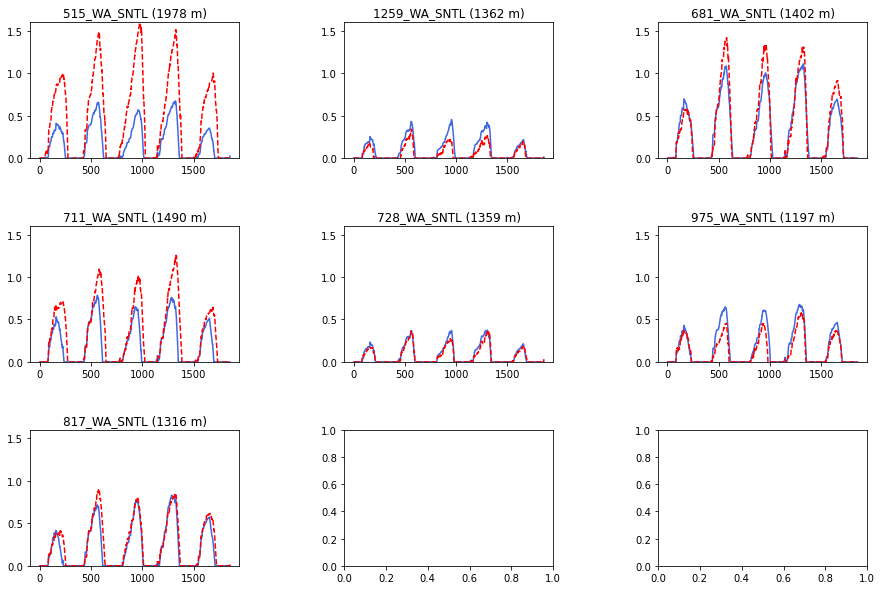

In [80]:
#Ranking plot OR -> one winning rank score 
elev = gdf['elevation_m'].values
station = gdf['code'].values

from matplotlib.pyplot import cm

n=np.shape(top_swe)[0]

fig, axs = plt.subplots(nrows=3, figsize=(15, 10), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(gdf)[0]):
    nam = station[i]
    el = elev[i]
    x = df[nam].values
    mod = np.squeeze(top_swe[:,:,i])
    color=iter(cm.YlGnBu_r(np.linspace(0,1,n+2)))
    axs[i].plot(mod,c='royalblue')
    axs[i].plot(x,'r--')
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    axs[i].set_ylim([0, 1.6])
#     if i == 0:
#         axs[i].legend([str(label[0]),str(label[1]),str(label[2]),'stn'],bbox_to_anchor=(1.05, 1), loc='upper left',)

In [81]:
fig.savefig(figpath+domain+'_SWE_top_calmetrics_2020-07_22_rank.pdf', format='pdf', dpi=300)

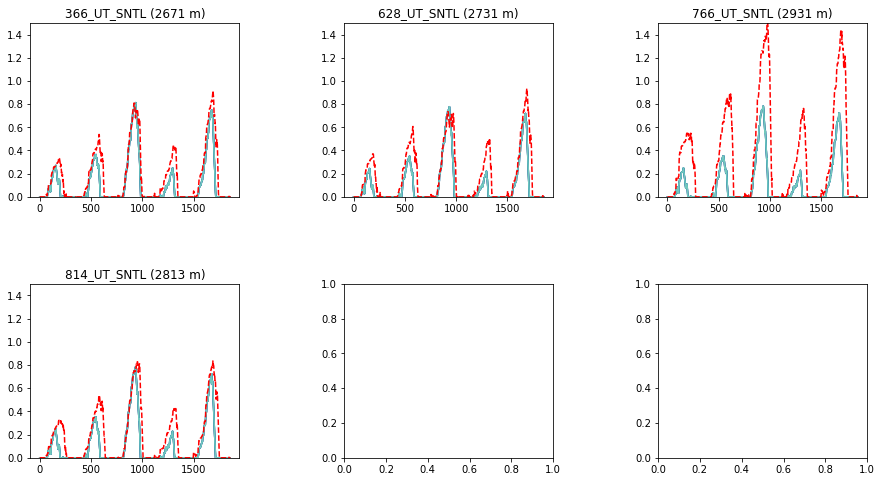

In [30]:
#Ranking plot WY
elev = gdf['elevation_m'].values
station = gdf['code'].values

from matplotlib.pyplot import cm

n=np.shape(top_swe)[0]

# label =[]
# label.append(dataav.iloc[top_params]['score_rank'])
# label

fig, axs = plt.subplots(nrows=2, figsize=(15, 8), ncols=3, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(np.shape(gdf)[0]):
    nam = station[i]
    el = elev[i]
    x = df[nam].values
    mod = np.squeeze(top_swe[:,:,i])
    color=iter(cm.YlGnBu_r(np.linspace(0,1,n+2)))
    for j in range(n):
        c=next(color)
        axs[i].plot(np.transpose(mod[j,:]),c=c)
    axs[i].plot(x,'r--')
    axs[i].set_title(nam+' ('+el[0:4]+' m)')
    axs[i].set_ylim([0, 1.5])
#     if i == 0:
#         axs[i].legend([str(label[0]),str(label[1]),str(label[2]),'stn'],bbox_to_anchor=(1.05, 1), loc='upper left',)

# Initiate full run of SM based on above findings

In [37]:
#the parameters for the top performing runs
calibration.loc[get_top_idx('KGE')]

lat_solar_flag                                                      1
lapse_rate           .28,1.2,2.8,4.2,4.5,4.4,4.0,3.8,3.7,3.4,2.6,0.87
prec_lapse_rate     0.35,0.35,0.35,0.30,0.25,0.20, 0.20,0.20,0.20,...
ro_snowmax                                                        475
cf_precip_scalar                                                    1
ro_adjust                                                           5
gap_frac                                                            0
Name: 8524, dtype: object

In [38]:
# need to discuss how to choose the top - currently set up to analyze based on OF

OF = 'KGE'

parFile = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill_full/snowmodel.par'

#function to edit SnowModel Files other than .par
def replace_line(file_name, line_num, text):
    lines = open(file_name, 'r').readlines()
    lines[line_num] = text
    out = open(file_name, 'w')
    out.writelines(lines)
    out.close()

##edit snowmodel.inc
replace_line(incFile, 12, '      parameter (nx_max='+domains[domain]['ncols']+',ny_max='+domains[domain]['nrows']+')\n')#full domain

#remove line flag
edit_par(base,'snowmodel_line_flag',0)
edit_par(base,'nx',domains[domain]['ncols'])
edit_par(base,'ny',domains[domain]['nrows'])
edit_par(base,'lat_solar_flag',calibration.lat_solar_flag.loc[get_top_idx(OF)])
edit_par(base,'lapse_rate',calibration.lapse_rate.loc[get_top_idx(OF)])
edit_par(base,'prec_lapse_rate',calibration.prec_lapse_rate.loc[get_top_idx(OF)])
edit_par(base,'ro_snowmax',calibration.ro_snowmax.loc[get_top_idx(OF)])
edit_par(base,'cf_precip_scalar',calibration.cf_precip_scalar.loc[get_top_idx(OF)])
edit_par(base,'ro_adjust',calibration.ro_adjust.loc[get_top_idx(OF)])  
    
#run compile script 
#Compile SnowModel

%cd /nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill_full/code/
! ./compile_snowmodel.script
%cd  $calpath

/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill_full/code
/nfs/attic/dfh/Aragon2/Notebooks/calibration_python


In [ ]:
# in command line - initiate the full model run
# $ cd /nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill_full/
# $ ! nohup ./snowmodel